In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar xf spark-3.3.0-bin-hadoop3.tgz

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"

!pip install -q findspark
import findspark
findspark.init()

In [ ]:
import sys
from pyspark.sql import SQLContext
from pyspark import SparkContext
import numpy as np
import pandas as pd
from pyspark.sql.functions import when, regexp_extract, col, split, to_timestamp
from pyspark.sql.types import IntegerType, StringType, DoubleType
from pyspark.ml.stat import Correlation
import seaborn as sns
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.feature import UnivariateFeatureSelector, VarianceThresholdSelector, PCA
from pyspark.ml.stat import ChiSquareTest, Summarizer
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.storagelevel import StorageLevel
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes

In [ ]:
sc = SparkContext()

In [ ]:
sql_c = SQLContext(sc)

/content/spark-3.3.0-bin-hadoop3/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
df_1 = sql_c.read.csv('/content/drive/MyDrive/Flight_Data/Combined_Flights_2018.csv', header=True, inferSchema=True)
df_2 = sql_c.read.csv('/content/drive/MyDrive/Flight_Data/Combined_Flights_2019.csv', header=True, inferSchema=True)
df_3 = sql_c.read.csv('/content/drive/MyDrive/Flight_Data/Combined_Flights_2020.csv', header=True, inferSchema=True)
df_4 = sql_c.read.csv('/content/drive/MyDrive/Flight_Data/Combined_Flights_2021.csv', header=True, inferSchema=True)
df_5 = sql_c.read.csv('/content/drive/MyDrive/Flight_Data/Combined_Flights_2022.csv', header=True, inferSchema=True)

In [ ]:
df_spark = df_1.union(df_2).union(df_3).union(df_4).union(df_5)

In [ ]:
df_spark.coalesce(1).write.mode("overwrite").options(header=True).csv('/content/drive/MyDrive/CS777_Project')

# Sampling

In [ ]:
df_sample = df_spark.sample(fraction=0.001, seed = 777)

In [ ]:
df_sample.count()

29179

In [ ]:
df_sample.filter(col('Year') == 2022).count()

4065

In [ ]:
df_sample.coalesce(1).write.mode("overwrite").options(header=True).csv('/content/drive/MyDrive/Flight_Small_Data')

# Working with small dataset

In [ ]:
df_spark_2 = sql_c.read.csv('/content/drive/MyDrive/Flight_Small_Data/flight_small_data.csv', header=True, inferSchema=True)

In [ ]:
df_spark_2.persist(StorageLevel.MEMORY_ONLY)

DataFrame[FlightDate: timestamp, Airline: string, Origin: string, Dest: string, Cancelled: boolean, Diverted: boolean, CRSDepTime: int, DepTime: double, DepDelayMinutes: double, DepDelay: double, ArrTime: double, ArrDelayMinutes: double, AirTime: double, CRSElapsedTime: double, ActualElapsedTime: double, Distance: double, Year: int, Quarter: int, Month: int, DayofMonth: int, DayOfWeek: int, Marketing_Airline_Network: string, Operated_or_Branded_Code_Share_Partners: string, DOT_ID_Marketing_Airline: int, IATA_Code_Marketing_Airline: string, Flight_Number_Marketing_Airline: int, Operating_Airline: string, DOT_ID_Operating_Airline: int, IATA_Code_Operating_Airline: string, Tail_Number: string, Flight_Number_Operating_Airline: int, OriginAirportID: int, OriginAirportSeqID: int, OriginCityMarketID: int, OriginCityName: string, OriginState: string, OriginStateFips: int, OriginStateName: string, OriginWac: int, DestAirportID: int, DestAirportSeqID: int, DestCityMarketID: int, DestCityName: st

In [ ]:
df_spark_2.show()

+-------------------+--------------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+-------------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|         FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|

In [ ]:
# Remove 'CRSDepTime', 'DepDelayMinutes', 'ArrDelayMinutes', 'CRSElapsedTime', ActualElapsedTime, 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
#      'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline', 'Flight_Number_Marketing_Airline', 'Operating_Airline',
#       'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline', 'Tail_Number', 'Flight_Number_Operating_Airline', 'Flight_Number_Operating_Airline',
#       'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'OriginStateFips', 'OriginStateName', 'OriginWac',
#       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestStateFips', 'DestStateName', 'DestWac', 'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk'
#       'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrDel15', 'ArrivalDelayGroups', 'ArrTimeBlk', 'DistanceGroup'

In [ ]:
remove_cols_list = ['FlightDate', 'CRSDepTime', 'DepDelayMinutes', 'ArrDelayMinutes', 'CRSElapsedTime', 'ActualElapsedTime', 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
                    'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline', 'Flight_Number_Marketing_Airline', 'Operating_Airline',
                    'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline', 'Tail_Number', 'Flight_Number_Operating_Airline', 'Flight_Number_Operating_Airline',
                    'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'OriginStateFips', 'OriginStateName', 'OriginWac',
                    'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestStateFips', 'DestStateName', 'DestWac', 'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk',
                    'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrDel15', 'ArrivalDelayGroups', 'ArrTimeBlk', 'DistanceGroup']

In [ ]:
df_spark_2 = df_spark_2.select([_ for _ in df_spark_2.columns if _ not in remove_cols_list])

In [ ]:
df_spark_3 = df_spark_2.filter(col('Cancelled') == True)

In [ ]:
# Keeping only not cancelled flights
df_spark_2 = df_spark_2.filter(col('Cancelled') == False)

In [ ]:
# Remove rows with null values
df_spark_2 = df_spark_2.na.drop()

In [ ]:
df_spark_3 = df_spark_3.union(df_spark_2)

In [ ]:
# Saving this dataset for visualization
df_spark_3.coalesce(1).write.mode("overwrite").options(header=True).csv('/content/drive/MyDrive/CS_777_Project_Osama/Flight_Small_Data_Visualization')

In [ ]:
df_spark_2 = df_spark_2.drop(col('Cancelled'))

In [ ]:
df_spark_2.show()

+--------------------+------+----+--------+-------+--------+-------+-------+--------+----+-------+-----+----------+---------+--------------------+-----------+-------------------+---------+--------+------------------+
|             Airline|Origin|Dest|Diverted|DepTime|DepDelay|ArrTime|AirTime|Distance|Year|Quarter|Month|DayofMonth|DayOfWeek|      OriginCityName|OriginState|       DestCityName|DestState|ArrDelay|DivAirportLandings|
+--------------------+------+----+--------+-------+--------+-------+-------+--------+----+-------+-----+----------+---------+--------------------+-----------+-------------------+---------+--------+------------------+
|   Endeavor Air Inc.|   BTV| DTW|   false| 1243.0|     3.0| 1453.0|  104.0|   537.0|2018|      1|    1|        16|        2|      Burlington, VT|         VT|        Detroit, MI|       MI|    -2.0|               0.0|
|   Endeavor Air Inc.|   CVG| MSP|   false| 1108.0|    -2.0| 1200.0|   94.0|   596.0|2018|      1|    1|         3|        3|      C

In [ ]:
df_spark_2.schema

StructType([StructField('Airline', StringType(), True), StructField('Origin', StringType(), True), StructField('Dest', StringType(), True), StructField('Diverted', BooleanType(), True), StructField('DepTime', DoubleType(), True), StructField('DepDelay', DoubleType(), True), StructField('ArrTime', DoubleType(), True), StructField('AirTime', DoubleType(), True), StructField('Distance', DoubleType(), True), StructField('Year', IntegerType(), True), StructField('Quarter', IntegerType(), True), StructField('Month', IntegerType(), True), StructField('DayofMonth', IntegerType(), True), StructField('DayOfWeek', IntegerType(), True), StructField('OriginCityName', StringType(), True), StructField('OriginState', StringType(), True), StructField('DestCityName', StringType(), True), StructField('DestState', StringType(), True), StructField('ArrDelay', DoubleType(), True), StructField('DivAirportLandings', DoubleType(), True)])

In [ ]:
# Setting a column delay status which will be the predicted variable (flight delayed or not)
df_spark_2 = df_spark_2.withColumn('Delay_Status', when((df_spark_2['DepDelay'] <= 0) & (df_spark_2['ArrDelay'] <= 0), 0).otherwise(1))

In [ ]:
df_spark_2.show()

+--------------------+------+----+--------+-------+--------+-------+-------+--------+----+-------+-----+----------+---------+--------------------+-----------+-------------------+---------+--------+------------------+------------+
|             Airline|Origin|Dest|Diverted|DepTime|DepDelay|ArrTime|AirTime|Distance|Year|Quarter|Month|DayofMonth|DayOfWeek|      OriginCityName|OriginState|       DestCityName|DestState|ArrDelay|DivAirportLandings|Delay_Status|
+--------------------+------+----+--------+-------+--------+-------+-------+--------+----+-------+-----+----------+---------+--------------------+-----------+-------------------+---------+--------+------------------+------------+
|   Endeavor Air Inc.|   BTV| DTW|   false| 1243.0|     3.0| 1453.0|  104.0|   537.0|2018|      1|    1|        16|        2|      Burlington, VT|         VT|        Detroit, MI|       MI|    -2.0|               0.0|           1|
|   Endeavor Air Inc.|   CVG| MSP|   false| 1108.0|    -2.0| 1200.0|   94.0|   5

In [ ]:
# Dropping columns DepDelay and ArrDelay because they directly drive the delay status
col_drop = ['DepDelay', 'ArrDelay']
df_spark_2 = df_spark_2.drop(*col_drop)

In [ ]:
df_spark_2.show()

+--------------------+------+----+--------+-------+-------+-------+--------+----+-------+-----+----------+---------+--------------------+-----------+-------------------+---------+------------------+------------+
|             Airline|Origin|Dest|Diverted|DepTime|ArrTime|AirTime|Distance|Year|Quarter|Month|DayofMonth|DayOfWeek|      OriginCityName|OriginState|       DestCityName|DestState|DivAirportLandings|Delay_Status|
+--------------------+------+----+--------+-------+-------+-------+--------+----+-------+-----+----------+---------+--------------------+-----------+-------------------+---------+------------------+------------+
|   Endeavor Air Inc.|   BTV| DTW|   false| 1243.0| 1453.0|  104.0|   537.0|2018|      1|    1|        16|        2|      Burlington, VT|         VT|        Detroit, MI|       MI|               0.0|           1|
|   Endeavor Air Inc.|   CVG| MSP|   false| 1108.0| 1200.0|   94.0|   596.0|2018|      1|    1|         3|        3|      Cincinnati, OH|         KY|   

In [ ]:
# Removing state from city name
df_spark_2 = df_spark_2.withColumn('OriginCityName', split(col('OriginCityName'),',').getItem(0))
df_spark_2 = df_spark_2.withColumn('DestCityName', split(col('DestCityName'),',').getItem(0))

In [ ]:
df_spark_2.show()

+--------------------+------+----+--------+-------+-------+-------+--------+----+-------+-----+----------+---------+--------------------+-----------+---------------+---------+------------------+------------+
|             Airline|Origin|Dest|Diverted|DepTime|ArrTime|AirTime|Distance|Year|Quarter|Month|DayofMonth|DayOfWeek|      OriginCityName|OriginState|   DestCityName|DestState|DivAirportLandings|Delay_Status|
+--------------------+------+----+--------+-------+-------+-------+--------+----+-------+-----+----------+---------+--------------------+-----------+---------------+---------+------------------+------------+
|   Endeavor Air Inc.|   BTV| DTW|   false| 1243.0| 1453.0|  104.0|   537.0|2018|      1|    1|        16|        2|          Burlington|         VT|        Detroit|       MI|               0.0|           1|
|   Endeavor Air Inc.|   CVG| MSP|   false| 1108.0| 1200.0|   94.0|   596.0|2018|      1|    1|         3|        3|          Cincinnati|         KY|    Minneapolis|   

In [ ]:
# Splitting arrival and departure times into columns with hours and minutes
df_spark_2 = df_spark_2.withColumn('DepTimeHour', when(col("DepTime") >= 1000, col("DepTime").cast(IntegerType()).cast(StringType()).substr(0,2))\
                                   .when((col("DepTime") >= 100) & (col("DepTime") < 1000), col("DepTime").cast(IntegerType()).cast(StringType()).substr(0,1))\
                                   .otherwise(0))
df_spark_2 = df_spark_2.withColumn('DepTimeMinute', col("DepTime").cast(IntegerType()).cast(StringType()).substr(-2,2))

df_spark_2 = df_spark_2.withColumn('ArrTimeHour', when(col("ArrTime") >= 1000, col("ArrTime").cast(IntegerType()).cast(StringType()).substr(0,2))\
                                   .when((col("ArrTime") >= 100) & (col("ArrTime") < 1000), col("ArrTime").cast(IntegerType()).cast(StringType()).substr(0,1))\
                                   .otherwise(0))
df_spark_2 = df_spark_2.withColumn('ArrTimeMinute', col("ArrTime").cast(IntegerType()).cast(StringType()).substr(-2,2))

df_spark_2 = df_spark_2.withColumn('DepTimeHour', col('DepTimeHour').cast(IntegerType()))\
.withColumn('DepTimeMinute', col('DepTimeMinute').cast(IntegerType()))\
.withColumn('ArrTimeHour', col('ArrTimeHour').cast(IntegerType()))\
.withColumn('ArrTimeMinute', col('ArrTimeMinute').cast(IntegerType()))

In [ ]:
df_spark_2.show()

+--------------------+------+----+--------+-------+-------+-------+--------+----+-------+-----+----------+---------+--------------------+-----------+---------------+---------+------------------+------------+-----------+-------------+-----------+-------------+
|             Airline|Origin|Dest|Diverted|DepTime|ArrTime|AirTime|Distance|Year|Quarter|Month|DayofMonth|DayOfWeek|      OriginCityName|OriginState|   DestCityName|DestState|DivAirportLandings|Delay_Status|DepTimeHour|DepTimeMinute|ArrTimeHour|ArrTimeMinute|
+--------------------+------+----+--------+-------+-------+-------+--------+----+-------+-----+----------+---------+--------------------+-----------+---------------+---------+------------------+------------+-----------+-------------+-----------+-------------+
|   Endeavor Air Inc.|   BTV| DTW|   false| 1243.0| 1453.0|  104.0|   537.0|2018|      1|    1|        16|        2|          Burlington|         VT|        Detroit|       MI|               0.0|           1|         12| 

In [ ]:
# Dropping the arrival and departure times now
col_drop = ['DepTime', 'ArrTime']
df_spark_2 = df_spark_2.drop(*col_drop)

In [ ]:
df_spark_2.show()

+--------------------+------+----+--------+-------+--------+----+-------+-----+----------+---------+--------------------+-----------+---------------+---------+------------------+------------+-----------+-------------+-----------+-------------+
|             Airline|Origin|Dest|Diverted|AirTime|Distance|Year|Quarter|Month|DayofMonth|DayOfWeek|      OriginCityName|OriginState|   DestCityName|DestState|DivAirportLandings|Delay_Status|DepTimeHour|DepTimeMinute|ArrTimeHour|ArrTimeMinute|
+--------------------+------+----+--------+-------+--------+----+-------+-----+----------+---------+--------------------+-----------+---------------+---------+------------------+------------+-----------+-------------+-----------+-------------+
|   Endeavor Air Inc.|   BTV| DTW|   false|  104.0|   537.0|2018|      1|    1|        16|        2|          Burlington|         VT|        Detroit|       MI|               0.0|           1|         12|           43|         14|           53|
|   Endeavor Air Inc.|  

In [ ]:
df_spark_2 = df_spark_2.withColumn('Diverted', col('Diverted').cast(IntegerType()))

In [ ]:
df_spark_2.coalesce(1).write.mode("overwrite").options(header=True).csv('/content/drive/MyDrive/CS_777_Project_Osama/Full_Cleaned_Data')

# Statistical Testing

## Correlation

In [ ]:
df_spark_2 = sql_c.read.csv('/content/drive/MyDrive/CS_777_Project/full_cleaned_data.csv', header=True, inferSchema=True)

In [ ]:
# Changing all catagorical columns to string index

In [ ]:
def def_cat_num_cols (x):
  categorical_cols = []
  numerical_cols = []

  col_types = x.dtypes

  for i in col_types:
    if i[1] == 'string':
      categorical_cols += [i[0]]
    else:
      if i[0] not in ['Year','Delay_Status']:
        numerical_cols += [i[0]]
  
  return categorical_cols, numerical_cols

In [ ]:
categorical_cols, numerical_cols = def_cat_num_cols(df_spark_2)

In [ ]:
categorical_cols

['Airline',
 'Origin',
 'Dest',
 'OriginCityName',
 'OriginState',
 'DestCityName',
 'DestState']

In [ ]:
numerical_cols

['Diverted',
 'AirTime',
 'Distance',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'DivAirportLandings',
 'DepTimeHour',
 'DepTimeMinute',
 'ArrTimeHour',
 'ArrTimeMinute']

In [ ]:
for i in categorical_cols:
  df_spark_2 = StringIndexer(inputCol=i, outputCol=i + '_string', handleInvalid='skip').fit(df_spark_2).transform(df_spark_2)

In [ ]:
df_spark_2.show()

+--------------------+------+----+--------+-------+--------+----+-------+-----+----------+---------+--------------------+-----------+---------------+---------+------------------+------------+-----------+-------------+-----------+-------------+--------------+-------------+-----------+---------------------+------------------+-------------------+----------------+
|             Airline|Origin|Dest|Diverted|AirTime|Distance|Year|Quarter|Month|DayofMonth|DayOfWeek|      OriginCityName|OriginState|   DestCityName|DestState|DivAirportLandings|Delay_Status|DepTimeHour|DepTimeMinute|ArrTimeHour|ArrTimeMinute|Airline_string|Origin_string|Dest_string|OriginCityName_string|OriginState_string|DestCityName_string|DestState_string|
+--------------------+------+----+--------+-------+--------+----+-------+-----+----------+---------+--------------------+-----------+---------------+---------+------------------+------------+-----------+-------------+-----------+-------------+--------------+-------------+--

In [ ]:
df_spark_2 = VectorAssembler(inputCols=[i + '_string' for i in categorical_cols]+numerical_cols+['Delay_Status'], outputCol='vector_assem_all', handleInvalid='skip').transform(df_spark_2)

In [ ]:
df_spark_2.show(truncate=False)

+------------------------+------+----+--------+-------+--------+----+-------+-----+----------+---------+----------------------+-----------+---------------+---------+------------------+------------+-----------+-------------+-----------+-------------+--------------+-------------+-----------+---------------------+------------------+-------------------+----------------+----------------------------------------------------------------------------------------------------+
|Airline                 |Origin|Dest|Diverted|AirTime|Distance|Year|Quarter|Month|DayofMonth|DayOfWeek|OriginCityName        |OriginState|DestCityName   |DestState|DivAirportLandings|Delay_Status|DepTimeHour|DepTimeMinute|ArrTimeHour|ArrTimeMinute|Airline_string|Origin_string|Dest_string|OriginCityName_string|OriginState_string|DestCityName_string|DestState_string|vector_assem_all                                                                                    |
+------------------------+------+----+--------+-------+-----

In [ ]:
r2 = Correlation.corr(df_spark_2, 'vector_assem_all').collect()[0][0].toArray()

In [ ]:
pd.DataFrame(r2).to_csv('/content/drive/MyDrive/numpy_array.csv', index=False)

In [ ]:
corr_data = pd.read_csv('/content/drive/MyDrive/CS_777_Big_Data/CS_777_Project_numpy_array.csv')

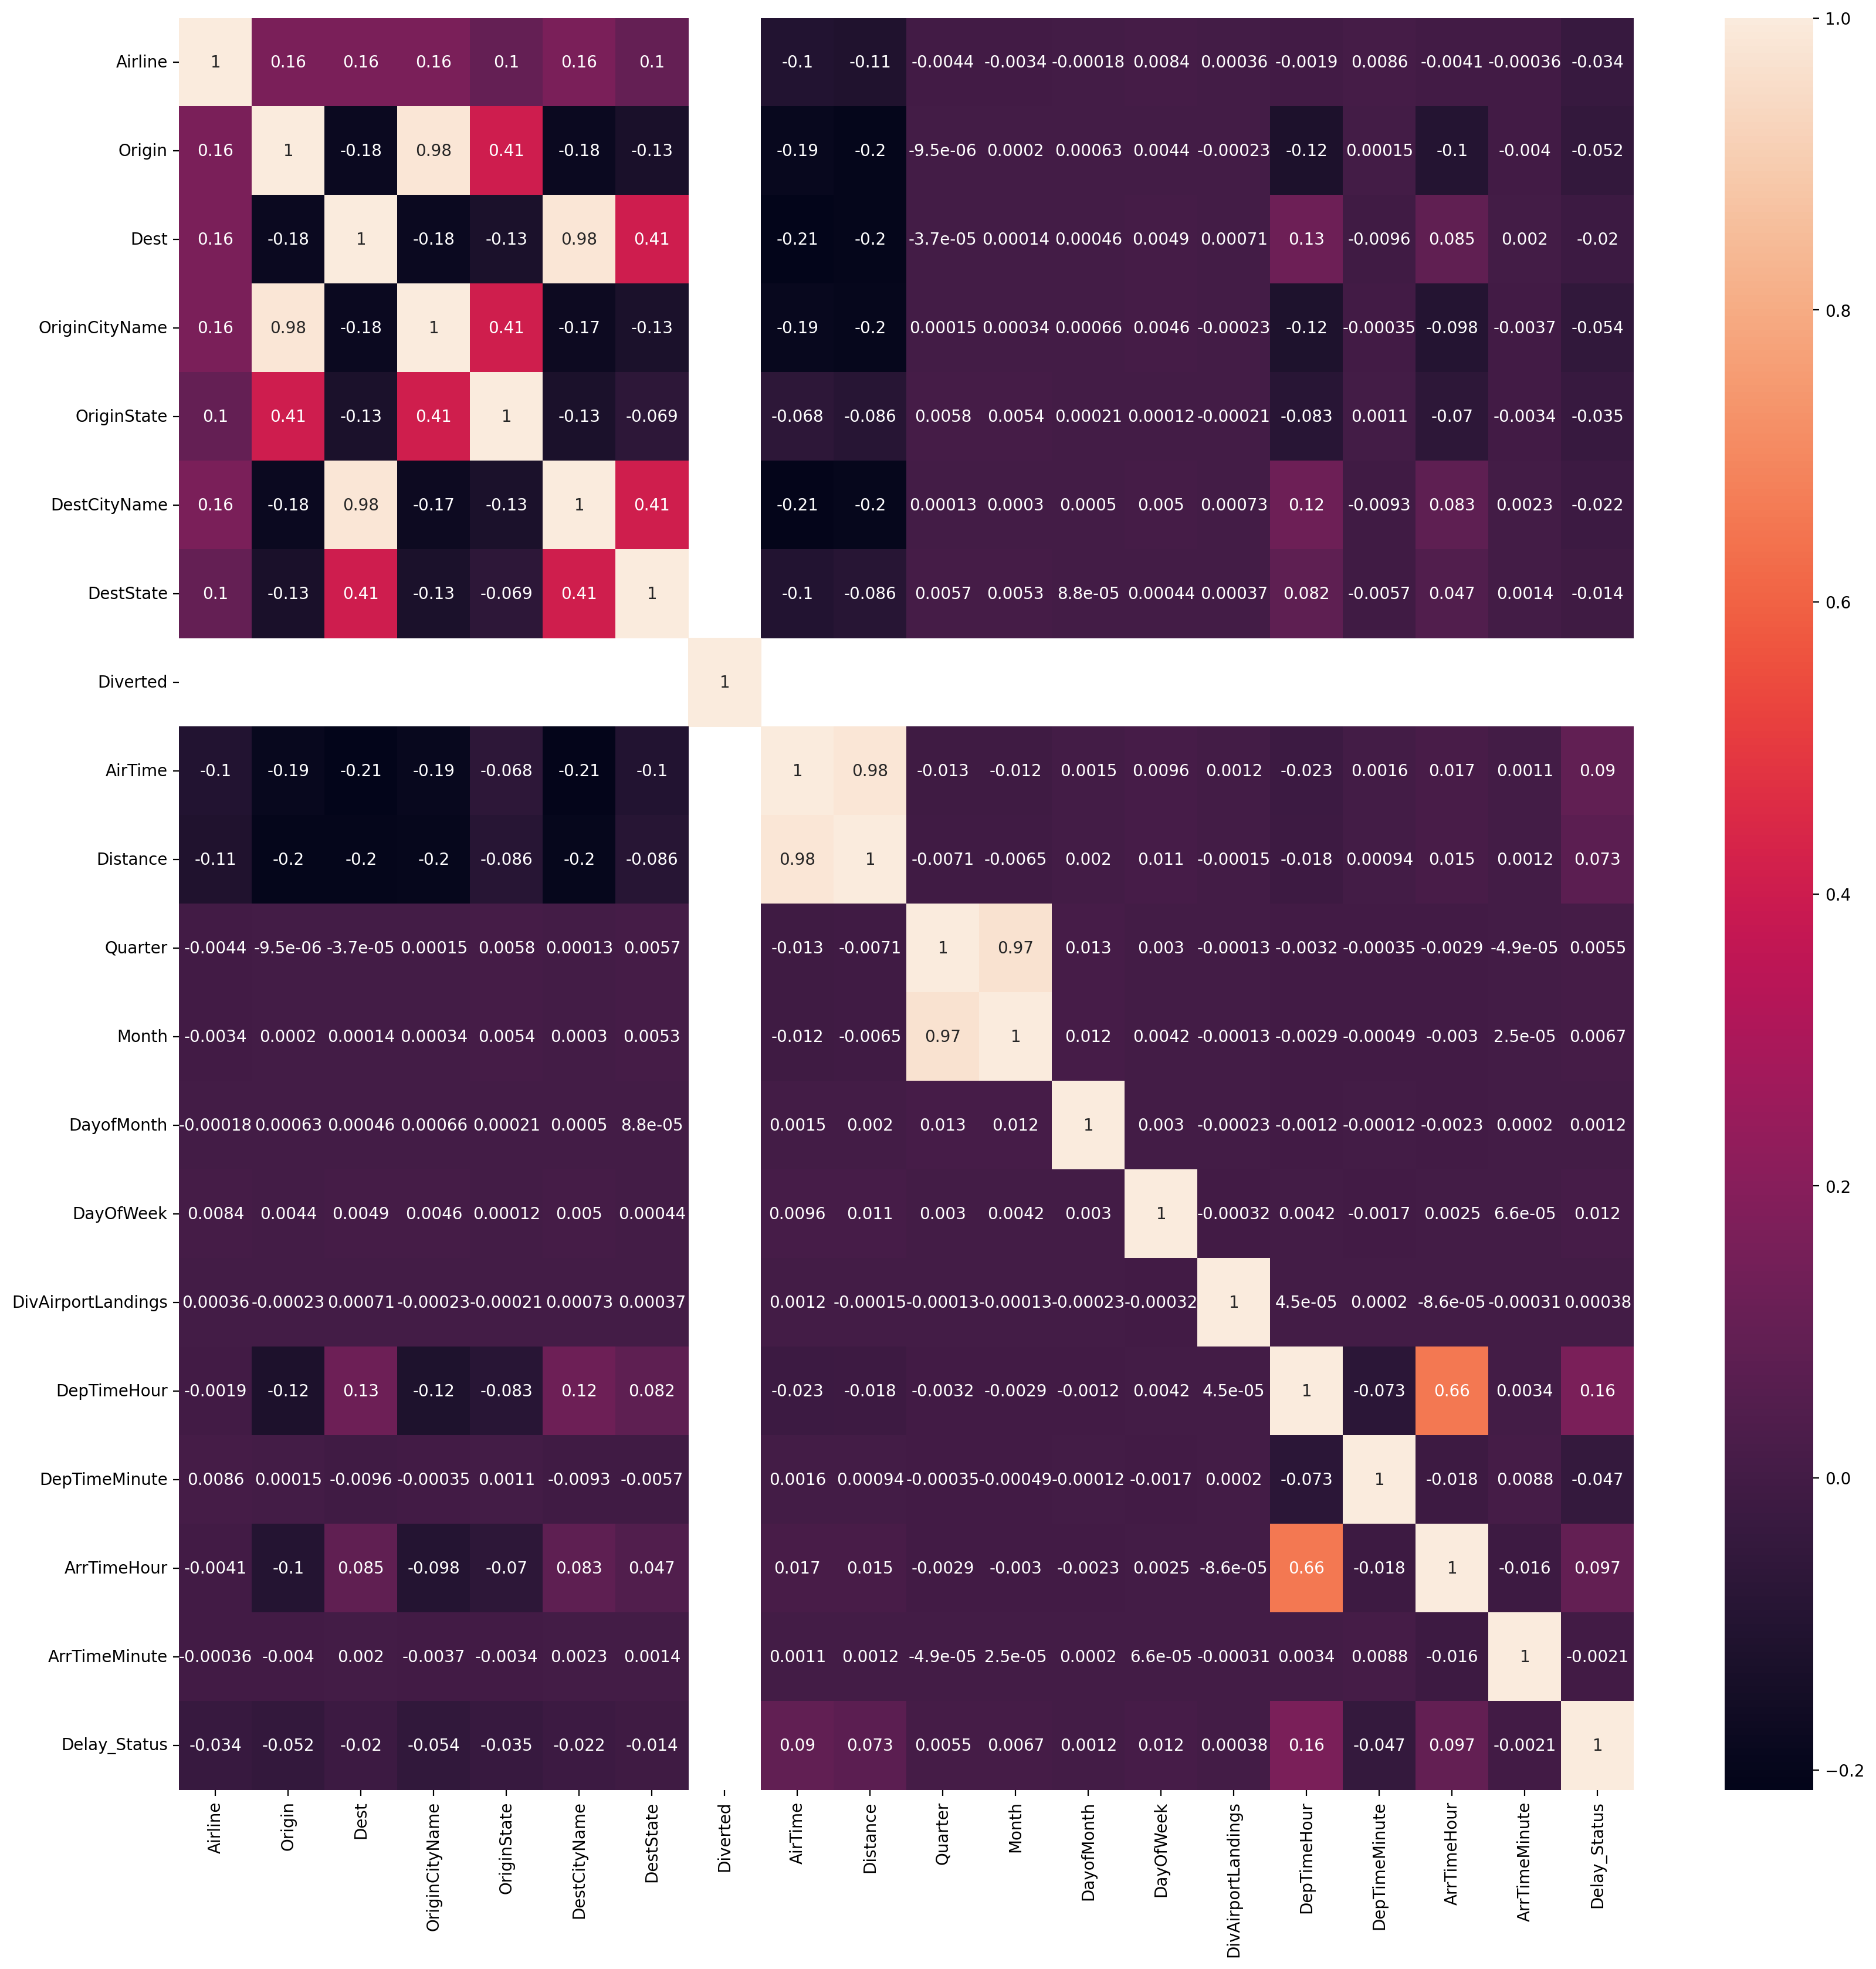

In [ ]:
figure(figsize=(20, 20), dpi=200)
corr_mat_plot = sns.heatmap(corr_data, annot=True, xticklabels=categorical_cols+numerical_cols+['Delay_Status'],\
                            yticklabels=categorical_cols+numerical_cols+['Delay_Status'])
corr_mat_plot.get_figure().savefig('/content/drive/MyDrive/CS_777_Big_Data/Correlation_Plot_Before.png')

In [ ]:
# Dropping Origin, Dest, Distance, Quarter
df_spark_2 = df_spark_2.drop('Origin', 'Dest', 'Distance', 'Quarter', 'vector_assem_all', 'Origin_string', 'Dest_string',\
                             'Distance_string', 'Quarter_string', 'Diverted')

In [ ]:
categorical_cols, numerical_cols = def_cat_num_cols(df_spark_2)

In [ ]:
temp = []

for i in categorical_cols:
  if i.find('_string') != -1:
    categorical_cols.remove(i)

for i in numerical_cols:
  if i.find('_string', 0) == -1:
    temp.append(i)

numerical_cols = temp

In [ ]:
df_spark_2 = VectorAssembler(inputCols=[i + '_string' for i in categorical_cols]+numerical_cols+['Delay_Status'], outputCol='vector_assem_all').transform(df_spark_2)

In [ ]:
r2 = Correlation.corr(df_spark_2, 'vector_assem_all').collect()[0][0].toArray()

In [ ]:
pd.DataFrame(r2).to_csv('/content/drive/MyDrive/corr_data_after.csv', index=False)

In [ ]:
corr_data = pd.read_csv('/content/drive/MyDrive/CS_777_Big_Data/CS_777_Project_corr_data_after.csv')

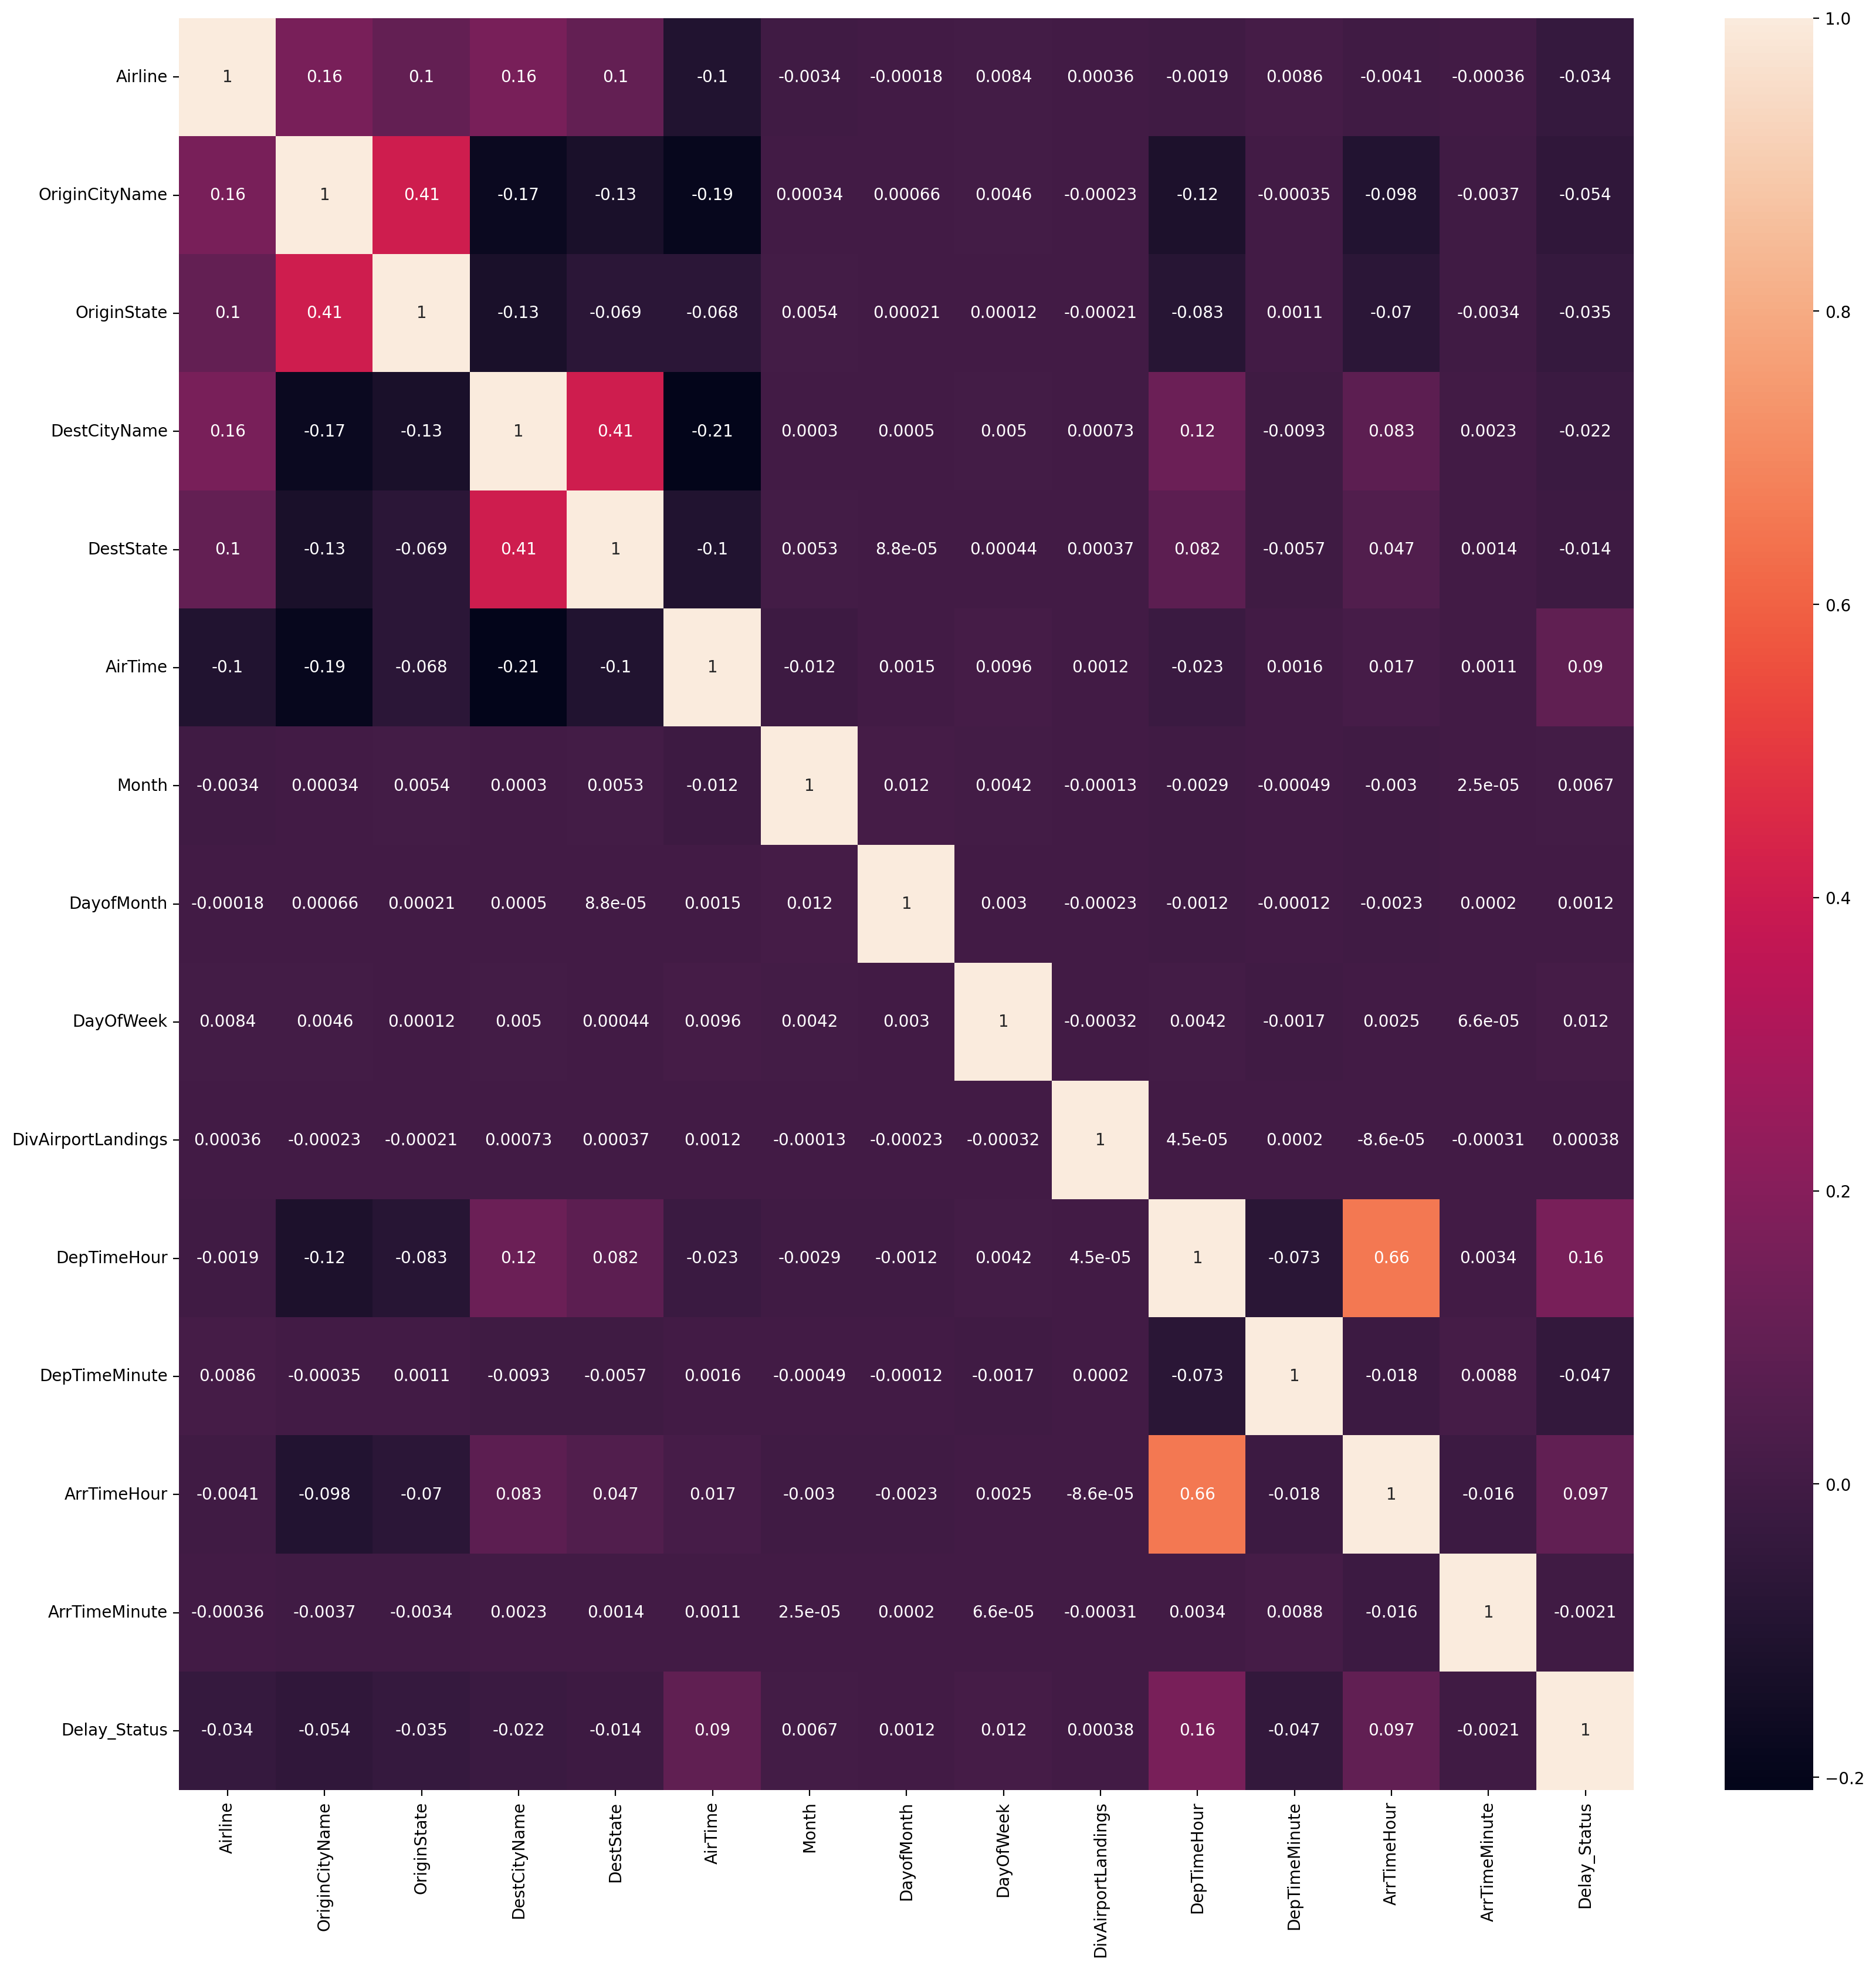

In [ ]:
figure(figsize=(20, 20), dpi=200)
corr_mat_after_plot = sns.heatmap(corr_data, annot=True, xticklabels=categorical_cols+numerical_cols+['Delay_Status'],\
                            yticklabels=categorical_cols+numerical_cols+['Delay_Status'])
corr_mat_after_plot.get_figure().savefig('/content/drive/MyDrive/CS_777_Big_Data/Correlation_Plot_After.png')

## Hypothesis Testing (Chi Squared Test)

In [ ]:
df_spark_2 = VectorAssembler(inputCols=[i + '_string' for i in categorical_cols], outputCol='vector_assem_cat', ).transform(df_spark_2)

In [ ]:
r = ChiSquareTest.test(df_spark_2, featuresCol='vector_assem_cat', labelCol='Delay_Status').collect()

In [ ]:
pd.DataFrame({'features': categorical_cols,'pValue': r[0][0], 'degreesOfFreedom': r[0][1], 'statistics': r[0][2]}).to_csv('/content/drive/MyDrive/CS_777_Project/chi_square_statistic.csv', index=False)

In [ ]:
r

[Row(pValues=DenseVector([0.0, 0.0, 0.0, 0.0, 0.0]), degreesOfFreedom=[27, 357, 51, 342, 51], statistics=DenseVector([427.7233, 622.5649, 218.9101, 490.326, 178.2008]))]

In [ ]:
df_spark_2.show()

+--------------------+-------+----+-----+----------+---------+--------------------+-----------+---------------+---------+------------------+------------+-----------+-------------+-----------+-------------+--------------+---------------------+------------------+-------------------+----------------+--------------------+--------------------+
|             Airline|AirTime|Year|Month|DayofMonth|DayOfWeek|      OriginCityName|OriginState|   DestCityName|DestState|DivAirportLandings|Delay_Status|DepTimeHour|DepTimeMinute|ArrTimeHour|ArrTimeMinute|Airline_string|OriginCityName_string|OriginState_string|DestCityName_string|DestState_string|    vector_assem_all|    vector_assem_cat|
+--------------------+-------+----+-----+----------+---------+--------------------+-----------+---------------+---------+------------------+------------+-----------+-------------+-----------+-------------+--------------+---------------------+------------------+-------------------+----------------+--------------------

# Feature Selection

## Univariate Feature Selection

In [ ]:
# create a assembly of numerical features and categorical features
df_spark_2 = VectorAssembler(inputCols=numerical_cols, outputCol='vector_assem_num').transform(df_spark_2)

In [ ]:
# selecting from categorical features
selector = UnivariateFeatureSelector(featuresCol="vector_assem_cat", outputCol="uni_cat_selectedFeatures",
                                     labelCol="Delay_Status", selectionMode="numTopFeatures")
selector.setFeatureType("categorical").setLabelType("categorical").setSelectionThreshold(3)

model_cat_uni = selector.fit(df_spark_2)

In [ ]:
# selecting from numerical features
selector = UnivariateFeatureSelector(featuresCol="vector_assem_num", outputCol="uni_num_selectedFeatures",
                                     labelCol="Delay_Status", selectionMode="numTopFeatures")
selector.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(7)

model_num_uni = selector.fit(df_spark_2)

In [ ]:
selector.getSelectionThreshold()

7.0

In [ ]:
categorical_cols

['Airline', 'OriginCityName', 'OriginState', 'DestCityName', 'DestState']

In [ ]:
uni_cat_selected_features = [categorical_cols[i] for i in model_cat_uni.selectedFeatures]

In [ ]:
uni_num_selected_features = [numerical_cols[i] for i in model_num_uni.selectedFeatures]

In [ ]:
pd.DataFrame({'selected_features': uni_cat_selected_features}).to_csv('/content/drive/MyDrive/CS_777_Project/univariate_categorical_feature_selection.csv', index=False)

In [ ]:
pd.DataFrame({'selected_features': uni_num_selected_features}).to_csv('/content/drive/MyDrive/CS_777_Project/univariate_numerical_feature_selection.csv', index=False)

## Variance Threshold Selector

In [ ]:
summarizer = Summarizer.metrics('variance')

In [ ]:
val_5 = sorted(df_spark_2.select(summarizer.summary(df_spark_2.vector_assem_num)).collect()[0][0][0].toArray(), reverse=True)[5]

In [ ]:
var_selected_features = [numerical_cols[i] for i in model_var.selectedFeatures]

In [ ]:
pd.DataFrame({'selected_features': var_selected_features}).to_csv('/content/drive/MyDrive/CS_777_Project/variance_feature_selection.csv', index=False)

In [ ]:
df_spark_2 = df_spark_2.drop('vector_assem_all', 'vector_assem_cat', 'vector_assem_num')

In [ ]:
df_spark_2 = df_spark_2.select([i for i in df_spark_2.columns if i.find('_string')==-1])

In [ ]:
df_spark_2.coalesce(1).write.mode("overwrite").options(header=True).csv('/content/drive/MyDrive/CS_777_Project/After_Statistics_Pre_Machine_Learning')

# Machine Learning

In [ ]:
df_spark_2 = sql_c.read.csv('/content/drive/MyDrive/CS_777_Project/After_Statistics_Pre_Machine_Learning/pre_machine_learning.csv', header=True, inferSchema=True)

In [ ]:
df_spark_2.persist(StorageLevel.MEMORY_ONLY)

DataFrame[Airline: string, AirTime: double, Year: int, Month: int, DayofMonth: int, DayOfWeek: int, OriginCityName: string, OriginState: string, DestCityName: string, DestState: string, DivAirportLandings: double, Delay_Status: int, DepTimeHour: int, DepTimeMinute: int, ArrTimeHour: int, ArrTimeMinute: int]

In [ ]:
df_spark_2.show()

+--------------------+-------+----+-----+----------+---------+--------------------+-----------+---------------+---------+------------------+------------+-----------+-------------+-----------+-------------+
|             Airline|AirTime|Year|Month|DayofMonth|DayOfWeek|      OriginCityName|OriginState|   DestCityName|DestState|DivAirportLandings|Delay_Status|DepTimeHour|DepTimeMinute|ArrTimeHour|ArrTimeMinute|
+--------------------+-------+----+-----+----------+---------+--------------------+-----------+---------------+---------+------------------+------------+-----------+-------------+-----------+-------------+
|   Endeavor Air Inc.|  104.0|2018|    1|        16|        2|          Burlington|         VT|        Detroit|       MI|               0.0|           1|         12|           43|         14|           53|
|   Endeavor Air Inc.|   94.0|2018|    1|         3|        3|          Cincinnati|         KY|    Minneapolis|       MN|               0.0|           0|         11|           

In [ ]:
numerical_cols_var = pd.read_csv('/content/drive/MyDrive/CS_777_Project/variance_feature_selection.csv').iloc[:,0].tolist()
catagorical_cols_uni = pd.read_csv('/content/drive/MyDrive/CS_777_Project/univariate_categorical_feature_selection.csv').iloc[:,0].tolist()
numerical_cols_uni = pd.read_csv('/content/drive/MyDrive/CS_777_Project/univariate_numerical_feature_selection.csv').iloc[:,0].tolist()

In [ ]:
numerical_cols = []
categorical_cols = []

for i in df_spark_2.dtypes:
  if i[1] == 'string':
    categorical_cols.append(i[0])
  elif i[0] not in ['Year', 'Delay_Status'] :
    numerical_cols.append(i[0])

In [ ]:
categorical_cols

['Airline', 'OriginCityName', 'OriginState', 'DestCityName', 'DestState']

In [ ]:
df_spark_2 = df_spark_2.withColumnRenamed('Delay_Status', 'label')

In [ ]:
train = df_spark_2.filter(col('Year') != 2022)
test = df_spark_2.filter(col('Year') == 2022)

In [ ]:
train.show()

+--------------------+-------+----+-----+----------+---------+--------------------+-----------+---------------+---------+------------------+-----+-----------+-------------+-----------+-------------+
|             Airline|AirTime|Year|Month|DayofMonth|DayOfWeek|      OriginCityName|OriginState|   DestCityName|DestState|DivAirportLandings|label|DepTimeHour|DepTimeMinute|ArrTimeHour|ArrTimeMinute|
+--------------------+-------+----+-----+----------+---------+--------------------+-----------+---------------+---------+------------------+-----+-----------+-------------+-----------+-------------+
|   Endeavor Air Inc.|  104.0|2018|    1|        16|        2|          Burlington|         VT|        Detroit|       MI|               0.0|    1|         12|           43|         14|           53|
|   Endeavor Air Inc.|   94.0|2018|    1|         3|        3|          Cincinnati|         KY|    Minneapolis|       MN|               0.0|    0|         11|            8|         12|            0|
|   E

In [ ]:
# Creating a function to create a pipline
def pipeline_creator (categorical_cols, numerical_cols, estimator):
  string_indexor = [StringIndexer(inputCol=i, outputCol=i + '_string', handleInvalid='skip') for i in categorical_cols]
  encoding = [OneHotEncoder(inputCol=f'{i}_string', outputCol=i + "_encoded") for i in categorical_cols]
  vector_assembler_1 = VectorAssembler(inputCols=numerical_cols, outputCol='vector_num')
  scaled = StandardScaler(inputCol='vector_num', outputCol='vector_num_scaled')
  inputAssembler = [f'{i}_encoded' for i in categorical_cols]
  inputAssembler += ['vector_num_scaled']
  vector_assembler_2 = VectorAssembler(inputCols=inputAssembler, outputCol='features')
  stages = []
  stages += string_indexor
  stages += encoding
  stages += [vector_assembler_1]
  stages += [scaled]
  stages += [vector_assembler_2]
  stages += [estimator]
  pipeline = Pipeline().setStages(stages)
  return pipeline

In [ ]:
temp_pipeline = pipeline_creator(categorical_cols, numerical_cols_var,1)

In [ ]:
temp_asdf = temp_pipeline.fit(train).transform(train)

In [ ]:
temp_asdf.show()

+--------------------+-------+----+-----+----------+---------+--------------------+-----------+---------------+---------+------------------+-----+-----------+-------------+-----------+-------------+--------------+---------------------+------------------+-------------------+----------------+---------------+----------------------+-------------------+--------------------+-----------------+--------------------+--------------------+--------------------+
|             Airline|AirTime|Year|Month|DayofMonth|DayOfWeek|      OriginCityName|OriginState|   DestCityName|DestState|DivAirportLandings|label|DepTimeHour|DepTimeMinute|ArrTimeHour|ArrTimeMinute|Airline_string|OriginCityName_string|OriginState_string|DestCityName_string|DestState_string|Airline_encoded|OriginCityName_encoded|OriginState_encoded|DestCityName_encoded|DestState_encoded|          vector_num|   vector_num_scaled|            features|
+--------------------+-------+----+-----+----------+---------+--------------------+-----------

In [ ]:
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
mcEvaluator_tpr = MulticlassClassificationEvaluator(metricName="truePositiveRateByLabel")
mcEvaluator_precision = MulticlassClassificationEvaluator(metricName="precisionByLabel")
mcEvaluator_fpr = MulticlassClassificationEvaluator(metricName="falsePositiveRateByLabel")
mcEvaluator_accuracy = MulticlassClassificationEvaluator(metricName="accuracy")
mcEvaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

## Logistic Regression

In [ ]:
lr = LogisticRegression()

In [ ]:
pipeline_full_data = pipeline_creator(categorical_cols, numerical_cols, lr)
pipeline_uni_data = pipeline_creator(catagorical_cols_uni, numerical_cols_uni, lr)
pipeline_var_data = pipeline_creator(categorical_cols, numerical_cols_var, lr)

In [ ]:
paramGrid_lr = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01, 0.05]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

In [ ]:
def logistic_regression_classification (pipeline, reg):
  if reg == 1:
    tvs = TrainValidationSplit(estimator=pipeline,
                            estimatorParamMaps=paramGrid_lr,
                            evaluator=bcEvaluator,
                            # 80% of the data will be used for training, 20% for validation.
                            trainRatio=0.8)
    model = tvs.fit(train)
    predictions = model.transform(test)
    best_parameters = sorted(list(zip(model.validationMetrics,model.getEstimatorParamMaps())), key= lambda x: x[0], reverse=True)[0]
    best_parameters = [best_parameters[1][i] for i in best_parameters[1].keys()]
  else:
    model = pipeline.fit(train)
    predictions = model.transform(test)
  area_roc = bcEvaluator.evaluate(predictions)
  accuracy = mcEvaluator_accuracy.evaluate(predictions)
  tpr = mcEvaluator_tpr.evaluate(predictions)
  fpr = mcEvaluator_fpr.evaluate(predictions)
  precision = mcEvaluator_precision.evaluate(predictions)
  f1_score = mcEvaluator_f1.evaluate(predictions)
  if reg == 1:
    df = pd.DataFrame({'parameter': ['regularization', 'elasticNet', 'area_ROC', 'accuracy', 'tpr', 'fpr', 'precision', 'f1_score'],\
                      'values': best_parameters + [area_roc,accuracy,tpr,fpr,precision,f1_score]})
  else:
    df = pd.DataFrame({'parameter': ['area_ROC', 'accuracy', 'tpr', 'fpr', 'precision', 'f1_score'],\
                      'values': [area_roc,accuracy,tpr,fpr,precision,f1_score]})
  return df

In [ ]:
lr_full_data_reg = logistic_regression_classification(pipeline_full_data, 1)
lr_uni_data_reg = logistic_regression_classification(pipeline_uni_data, 1)
lr_var_data_reg = logistic_regression_classification(pipeline_var_data, 1)
lr_full_data = logistic_regression_classification(pipeline_full_data, 0)
lr_uni_data = logistic_regression_classification(pipeline_uni_data, 0)
lr_var_data = logistic_regression_classification(pipeline_var_data, 0)

In [ ]:
lr_full_data_reg.to_csv('/content/drive/MyDrive/CS_777_Project/Logistic_Regression_Regularization_Full_Data_Metrics.csv', index=False)
lr_uni_data_reg.to_csv('/content/drive/MyDrive/CS_777_Project/Logistic_Regression_Regularization_Uni_Data_Metrics.csv', index=False)
lr_var_data_reg.to_csv('/content/drive/MyDrive/CS_777_Project/Logistic_Regression_Regularization_Var_Data_Metrics.csv', index=False)
lr_full_data.to_csv('/content/drive/MyDrive/CS_777_Project/Logistic_Regression_Full_Data_Metrics.csv', index=False)
lr_uni_data.to_csv('/content/drive/MyDrive/CS_777_Project/Logistic_Regression_Uni_Data_Metrics.csv', index=False)
lr_var_data.to_csv('/content/drive/MyDrive/CS_777_Project/Logistic_Regression_Var_Data_Metrics.csv', index=False)

## Logistic Regression with Cross Validation

In [ ]:
def cv_lr_classification(pipeline):
  cross_val = CrossValidator(estimator=pipeline,
                            estimatorParamMaps=paramGrid_lr,
                            evaluator=bcEvaluator,
                            numFolds=10,
                            parallelism=10)
  model = cross_val.fit(train)
  predictions = model.transform(test)
  best_parameters = sorted(list(zip(model.avgMetrics,model.getEstimatorParamMaps())), key= lambda x: x[0], reverse=True)[0]
  best_parameters = [best_parameters[1][i] for i in best_parameters[1].keys()]
  area_roc = bcEvaluator.evaluate(predictions)
  accuracy = mcEvaluator_accuracy.evaluate(predictions)
  tpr = mcEvaluator_tpr.evaluate(predictions)
  fpr = mcEvaluator_fpr.evaluate(predictions)
  precision = mcEvaluator_precision.evaluate(predictions)
  f1_score = mcEvaluator_f1.evaluate(predictions)
  df = pd.DataFrame({'parameter': ['regularization', 'elasticNet', 'area_ROC', 'accuracy', 'tpr', 'fpr', 'precision', 'f1_score'],\
                      'values': best_parameters + [area_roc,accuracy,tpr,fpr,precision,f1_score]})
  return df

In [ ]:
cv_lr_full_data_reg = cv_lr_classification(pipeline_full_data)
cv_lr_uni_data_reg = cv_lr_classification(pipeline_uni_data)
cv_lr_var_data_reg = cv_lr_classification(pipeline_var_data)

In [ ]:
cv_lr_full_data_reg

,parameter,values
0,regularization,0.010000
1,elasticNet,0.500000
2,area_ROC,0.650496
3,accuracy,0.588968
4,tpr,0.903969
5,fpr,0.750660
6,precision,0.564911
7,f1_score,0.538102


In [ ]:
cv_lr_full_data_reg.to_csv('/content/drive/MyDrive/CS_777_Project/CV_Logistic_Regression_Regularization_Full_Data_Metrics.csv', index=False)
cv_lr_uni_data_reg.to_csv('/content/drive/MyDrive/CS_777_Project/CV_Logistic_Regression_Regularization_Uni_Data_Metrics.csv', index=False)
cv_lr_var_data_reg.to_csv('/content/drive/MyDrive/CS_777_Project/CV_Logistic_Regression_Regularization_Var_Data_Metrics.csv', index=False)

## Decision Tree

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
pipeline_full_data_dt = pipeline_creator(categorical_cols, numerical_cols, dt)
pipeline_uni_data_dt = pipeline_creator(catagorical_cols_uni, numerical_cols_uni, dt)
pipeline_var_data_dt = pipeline_creator(categorical_cols, numerical_cols_var, dt)

In [ ]:
paramGrid_dt = ParamGridBuilder()\
    .addGrid(dt.impurity, ['gini', 'entropy'])\
    .addGrid(dt.maxDepth, [5, 10, 15, 20])\
    .build()

In [ ]:
def decision_tree_classification (pipeline):
  tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid_dt,
                           evaluator=bcEvaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)
  model = tvs.fit(train)
  predictions = model.transform(test)
  best_parameters = sorted(list(zip(model.validationMetrics,model.getEstimatorParamMaps())), key= lambda x: x[0], reverse=True)[0]
  best_parameters = [best_parameters[1][i] for i in best_parameters[1].keys()]
  area_roc = bcEvaluator.evaluate(predictions)
  accuracy = mcEvaluator_accuracy.evaluate(predictions)
  tpr = mcEvaluator_tpr.evaluate(predictions)
  fpr = mcEvaluator_fpr.evaluate(predictions)
  precision = mcEvaluator_precision.evaluate(predictions)
  f1_score = mcEvaluator_f1.evaluate(predictions)
  df = pd.DataFrame({'parameter': ['impurity', 'maxDepth', 'area_ROC', 'accuracy', 'tpr', 'fpr', 'precision', 'f1_score'],\
                     'values': best_parameters + [area_roc,accuracy,tpr,fpr,precision,f1_score]})
  return df

In [ ]:
dt_full_data = decision_tree_classification(pipeline_full_data_dt)
dt_uni_data = decision_tree_classification(pipeline_uni_data_dt)
dt_var_data = decision_tree_classification(pipeline_var_data_dt)

In [ ]:
dt_full_data

,parameter,values
0,impurity,gini
1,maxDepth,5
2,area_ROC,1.0
3,accuracy,1.0
4,tpr,1.0
5,fpr,0.0
6,precision,1.0
7,f1_score,1.0


In [ ]:
dt_full_data.to_csv('/content/drive/MyDrive/CS_777_Project/Decision_Tree_Full_Data_Metrics.csv', index=False)
dt_uni_data.to_csv('/content/drive/MyDrive/CS_777_Project/Decision_Tree_Uni_Data_Metrics.csv', index=False)
dt_var_data.to_csv('/content/drive/MyDrive/CS_777_Project/Decision_Tree_Var_Data_Metrics.csv', index=False)

# Random Forest

In [ ]:
rf = RandomForestClassifier()

In [ ]:
pipeline_full_data_rf = pipeline_creator(categorical_cols, numerical_cols, rf)
pipeline_uni_data_rf = pipeline_creator(catagorical_cols_uni, numerical_cols_uni, rf)
pipeline_var_data_rf = pipeline_creator(categorical_cols, numerical_cols_var, rf)

In [ ]:
paramGrid_rf = ParamGridBuilder()\
    .addGrid(rf.impurity, ['gini', 'entropy'])\
    .addGrid(rf.maxDepth, [5, 10, 15, 20])\
    .addGrid(rf.numTrees, [5, 10, 15, 20])\
    .build()

In [ ]:
def random_forest_classification (pipeline):
  tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid_rf,
                           evaluator=bcEvaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)
  model = tvs.fit(train)
  predictions = model.transform(test)
  best_parameters = sorted(list(zip(model.validationMetrics,model.getEstimatorParamMaps())), key= lambda x: x[0], reverse=True)[0]
  best_parameters = [best_parameters[1][i] for i in best_parameters[1].keys()]
  area_roc = bcEvaluator.evaluate(predictions)
  accuracy = mcEvaluator_accuracy.evaluate(predictions)
  tpr = mcEvaluator_tpr.evaluate(predictions)
  fpr = mcEvaluator_fpr.evaluate(predictions)
  precision = mcEvaluator_precision.evaluate(predictions)
  f1_score = mcEvaluator_f1.evaluate(predictions)
  df = pd.DataFrame({'parameter': ['impurity', 'maxDepth', 'numTrees', 'area_ROC', 'accuracy', 'tpr', 'fpr', 'precision', 'f1_score'],\
                     'values': best_parameters + [area_roc,accuracy,tpr,fpr,precision,f1_score]})
  return df

In [ ]:
rf_full_data = random_forest_classification(pipeline_full_data_rf)
rf_uni_data = random_forest_classification(pipeline_uni_data_rf)
rf_var_data = random_forest_classification(pipeline_var_data_rf)

In [ ]:
rf_full_data.to_csv('/content/drive/MyDrive/CS_777_Project/Random_Forest_Full_Data_Metrics.csv', index=False)
rf_uni_data.to_csv('/content/drive/MyDrive/CS_777_Project/Random_Forest_Uni_Data_Metrics.csv', index=False)
rf_var_data.to_csv('/content/drive/MyDrive/CS_777_Project/Random_Forest_Var_Data_Metrics.csv', index=False)

## Gradient Boosted Trees

In [ ]:
gbt = GBTClassifier()

In [ ]:
pipeline_full_data_gbt = pipeline_creator(categorical_cols, numerical_cols, gbt)
pipeline_uni_data_gbt = pipeline_creator(catagorical_cols_uni, numerical_cols_uni, gbt)
pipeline_var_data_gbt = pipeline_creator(categorical_cols, numerical_cols_var, gbt)

In [ ]:
paramGrid_gbt = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [5, 10, 15, 20])\
    .build()

In [ ]:
def gradient_boosted_trees_classification (pipeline):
  tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid_gbt,
                           evaluator=bcEvaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)
  model = tvs.fit(train)
  predictions = model.transform(test)
  best_parameters = sorted(list(zip(model.validationMetrics,model.getEstimatorParamMaps())), key= lambda x: x[0], reverse=True)[0]
  best_parameters = [best_parameters[1][i] for i in best_parameters[1].keys()]
  area_roc = bcEvaluator.evaluate(predictions)
  accuracy = mcEvaluator_accuracy.evaluate(predictions)
  tpr = mcEvaluator_tpr.evaluate(predictions)
  fpr = mcEvaluator_fpr.evaluate(predictions)
  precision = mcEvaluator_precision.evaluate(predictions)
  f1_score = mcEvaluator_f1.evaluate(predictions)
  df = pd.DataFrame({'parameter': ['maxDepth', 'area_ROC', 'accuracy', 'tpr', 'fpr', 'precision', 'f1_score'],\
                     'values': best_parameters + [area_roc,accuracy,tpr,fpr,precision,f1_score]})
  return df

In [ ]:
gbt_full_data = gradient_boosted_trees_classification(pipeline_full_data_gbt)
gbt_uni_data = gradient_boosted_trees_classification(pipeline_uni_data_gbt)
gbt_var_data = gradient_boosted_trees_classification(pipeline_var_data_gbt)

In [ ]:
gbt_full_data.to_csv('/content/drive/MyDrive/CS_777_Project/Gradient_Boosted_Tree_Full_Data_Metrics.csv', index=False)
gbt_uni_data.to_csv('/content/drive/MyDrive/CS_777_Project/Gradient_Boosted_Tree_Uni_Data_Metrics.csv', index=False)
gbt_var_data.to_csv('/content/drive/MyDrive/CS_777_Project/Gradient_Boosted_Tree_Var_Data_Metrics.csv', index=False)

## Support Vector Machines

In [ ]:
lsvc = LinearSVC()

In [ ]:
pipeline_full_data_lsvc = pipeline_creator(categorical_cols, numerical_cols, lsvc)
pipeline_uni_data_lsvc = pipeline_creator(catagorical_cols_uni, numerical_cols_uni, lsvc)
pipeline_var_data_lsvc = pipeline_creator(categorical_cols, numerical_cols_var, lsvc)

In [ ]:
paramGrid_lsvc = ParamGridBuilder()\
    .addGrid(lsvc.regParam, [0.0, 0.3, 0.5, 1.0, 2.0])\
    .build()

In [ ]:
def lsvc_classification (pipeline):
  tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid_lsvc,
                           evaluator=bcEvaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)
  model = tvs.fit(train)
  predictions = model.transform(test)
  best_parameters = sorted(list(zip(model.validationMetrics,model.getEstimatorParamMaps())), key= lambda x: x[0], reverse=True)[0]
  best_parameters = [best_parameters[1][i] for i in best_parameters[1].keys()]
  area_roc = bcEvaluator.evaluate(predictions)
  accuracy = mcEvaluator_accuracy.evaluate(predictions)
  tpr = mcEvaluator_tpr.evaluate(predictions)
  fpr = mcEvaluator_fpr.evaluate(predictions)
  precision = mcEvaluator_precision.evaluate(predictions)
  f1_score = mcEvaluator_f1.evaluate(predictions)
  df = pd.DataFrame({'parameter': ['reg_param', 'area_ROC', 'accuracy', 'tpr', 'fpr', 'precision', 'f1_score'],\
                     'values': best_parameters + [area_roc,accuracy,tpr,fpr,precision,f1_score]})
  return df

In [ ]:
lsvc_full_data = lsvc_classification(pipeline_full_data_lsvc)
lsvc_uni_data = lsvc_classification(pipeline_uni_data_lsvc)
lsvc_var_data = lsvc_classification(pipeline_var_data_lsvc)

In [ ]:
lsvc_full_data

,parameter,values
0,reg_param,0.500000
1,area_ROC,0.621508
2,accuracy,0.517794
3,tpr,0.995590
4,fpr,0.997359
5,precision,0.518367
6,f1_score,0.356230


In [ ]:
lsvc_full_data.to_csv('/content/drive/MyDrive/CS_777_Project/Linear_SVC_Full_Data_Metrics.csv', index=False)
lsvc_uni_data.to_csv('/content/drive/MyDrive/CS_777_Project/Linear_SVC_Uni_Data_Metrics.csv', index=False)
lsvc_var_data.to_csv('/content/drive/MyDrive/CS_777_Project/Linear_SVC_Var_Data_Metrics.csv', index=False)

## Gaussian Naive Bayes

In [ ]:
nb = NaiveBayes(modelType='gaussian')

In [ ]:
pipeline_full_data_nb = pipeline_creator(categorical_cols, numerical_cols, nb)
pipeline_uni_data_nb = pipeline_creator(catagorical_cols_uni, numerical_cols_uni, nb)
pipeline_var_data_nb = pipeline_creator(categorical_cols, numerical_cols_var, nb)

In [ ]:
paramGrid_nb = ParamGridBuilder()\
    .addGrid(nb.smoothing, [0.0, 0.3, 0.5, 0.7, 1.0])\
    .build()

In [ ]:
def nb_classification (pipeline):
  tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid_nb,
                           evaluator=bcEvaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)
  model = tvs.fit(train)
  predictions = model.transform(test)
  best_parameters = sorted(list(zip(model.validationMetrics,model.getEstimatorParamMaps())), key= lambda x: x[0], reverse=True)[0]
  best_parameters = [best_parameters[1][i] for i in best_parameters[1].keys()]
  area_roc = bcEvaluator.evaluate(predictions)
  accuracy = mcEvaluator_accuracy.evaluate(predictions)
  tpr = mcEvaluator_tpr.evaluate(predictions)
  fpr = mcEvaluator_fpr.evaluate(predictions)
  precision = mcEvaluator_precision.evaluate(predictions)
  f1_score = mcEvaluator_f1.evaluate(predictions)
  df = pd.DataFrame({'parameter': ['smoothing_param', 'area_ROC', 'accuracy', 'tpr', 'fpr', 'precision', 'f1_score'],\
                     'values': best_parameters + [area_roc,accuracy,tpr,fpr,precision,f1_score]})
  return df

In [ ]:
nb_full_data = nb_classification(pipeline_full_data_nb)
nb_uni_data = nb_classification(pipeline_uni_data_nb)
nb_var_data = nb_classification(pipeline_var_data_nb)

In [ ]:
nb_full_data

,parameter,values
0,smoothing_param,0.000000
1,area_ROC,0.553382
2,accuracy,0.490086
3,tpr,0.060755
4,fpr,0.047015
5,precision,0.582160
6,f1_score,0.366333


In [ ]:
nb_full_data.to_csv('/content/drive/MyDrive/CS_777_Project/Naive_Bayes_Full_Data_Metrics.csv', index=False)
nb_uni_data.to_csv('/content/drive/MyDrive/CS_777_Project/Naive_Bayes_Uni_Data_Metrics.csv', index=False)
nb_var_data.to_csv('/content/drive/MyDrive/CS_777_Project/Naive_Bayes_Var_Data_Metrics.csv', index=False)

## Multi Layer Perceptron

In [ ]:
layers_wo_input = [[200,200,2], [300,300,300,2], [500,500,500,2]]


def mlp_classification (categorical_cols, numerical_cols, input_layer):
  layers = [[input_layer] + i for i in layers_wo_input]
  scores_list = []

  for i in layers:
    mlp = MultilayerPerceptronClassifier(layers=i)
    pipeline = pipeline_creator(categorical_cols, numerical_cols, mlp)
    model = pipeline.fit(train)
    predictions = model.transform(test)

    area_roc = bcEvaluator.evaluate(predictions)
    accuracy = mcEvaluator_accuracy.evaluate(predictions)
    tpr = mcEvaluator_tpr.evaluate(predictions)
    fpr = mcEvaluator_fpr.evaluate(predictions)
    precision = mcEvaluator_precision.evaluate(predictions)
    f1_score = mcEvaluator_f1.evaluate(predictions)

    scores_list.append([area_roc,accuracy,tpr,fpr,precision,f1_score])
  
  init = scores_list[0][0]
  sel = 0

  for i in range(1,len(scores_list)):
    if scores_list[i][0] > init:
        sel = i
        init = scores_list[i][0]
  df = pd.DataFrame({'parameter': ['layers', 'area_ROC', 'accuracy', 'tpr', 'fpr', 'precision', 'f1_score'],\
                     'values': [layers[sel],scores_list[sel][0],scores_list[sel][1],scores_list[sel][2],scores_list[sel][3],scores_list[sel][4],scores_list[sel][5]]})
  return df

In [ ]:
mlp_full_data = mlp_classification(categorical_cols, numerical_cols, 827)
mlp_uni_data = mlp_classification(catagorical_cols_uni, numerical_cols_uni, 438)
mlp_var_data = mlp_classification(categorical_cols, numerical_cols_var, 823)

In [ ]:
mlp_uni_data = mlp_classification(catagorical_cols_uni, numerical_cols_uni, 438)

In [ ]:
mlp_full_data.to_csv('/content/drive/MyDrive/CS_777_Project/Multi_Layer_Perceptron_Full_Data_Metrics.csv', index=False)
mlp_uni_data.to_csv('/content/drive/MyDrive/CS_777_Project/Multi_Layer_Perceptron_Uni_Data_Metrics.csv', index=False)
mlp_var_data.to_csv('/content/drive/MyDrive/CS_777_Project/Multi_Layer_Perceptron_Var_Data_Metrics.csv', index=False)